# Intro

Simple agenda here: we're going to load the motifs/TFs mapping and then make some pretty histograms showing the mapping

In [2]:
# Load the data, ggplot/ggpubr, and dplyr
library(dplyr)
library(ggpubr)

tf.motifs <- readRDS("../../trenadb/fimo/2017_08_23_Motif_TF_Map.RDS")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: magrittr


In [3]:
str(tf.motifs)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	13242 obs. of  2 variables:
 $ Motif: chr  "Mmusculus-UniPROBE-Sp100.UP00049" "Mmusculus-jaspar2016-Hes1-MA1099.1" "Mmusculus-jaspar2016-Hes1-MA1099.1" "Mmusculus-jaspar2016-Hes1-MA1099.1" ...
 $ TF   : chr  "SP140L" "HEY2" "HEY1" "HES7" ...


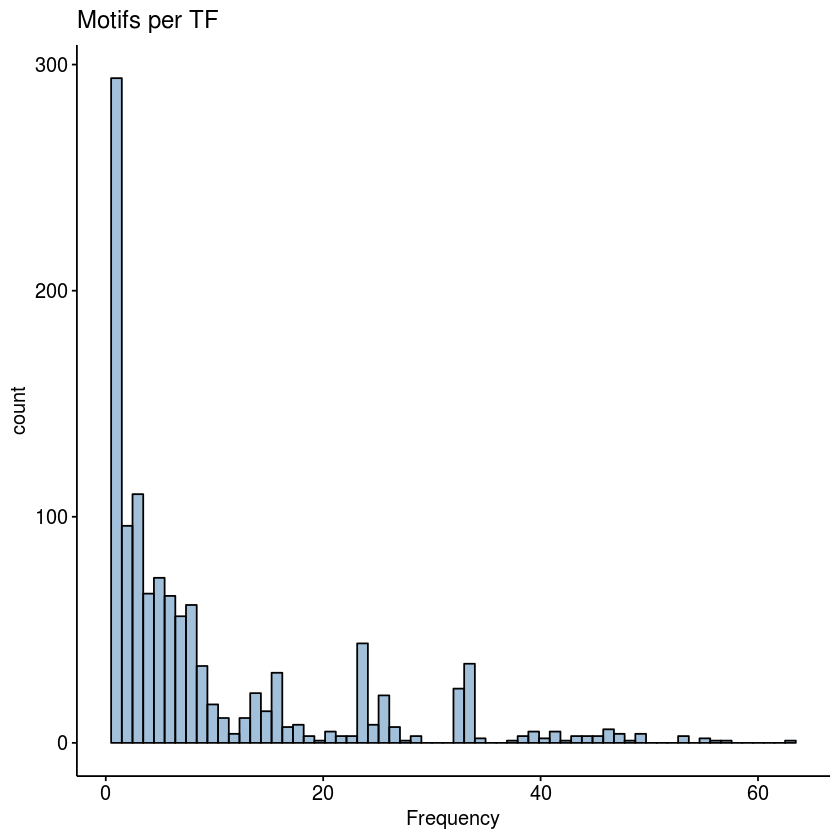

In [9]:
# Make a plot of just Jaspar motifs
tf.motifs %>% filter(grepl("jaspar2016",Motif)) %>%
    group_by(TF) %>%
    summarise(Frequency = n()) %>%
    arrange(desc(Frequency)) %>%
    gghistogram(x = "Frequency", 
                color = "black", 
                fill = "steelblue",
                bins = 64, 
                title = "Motifs per TF") -> motifs.per.tf
motifs.per.tf

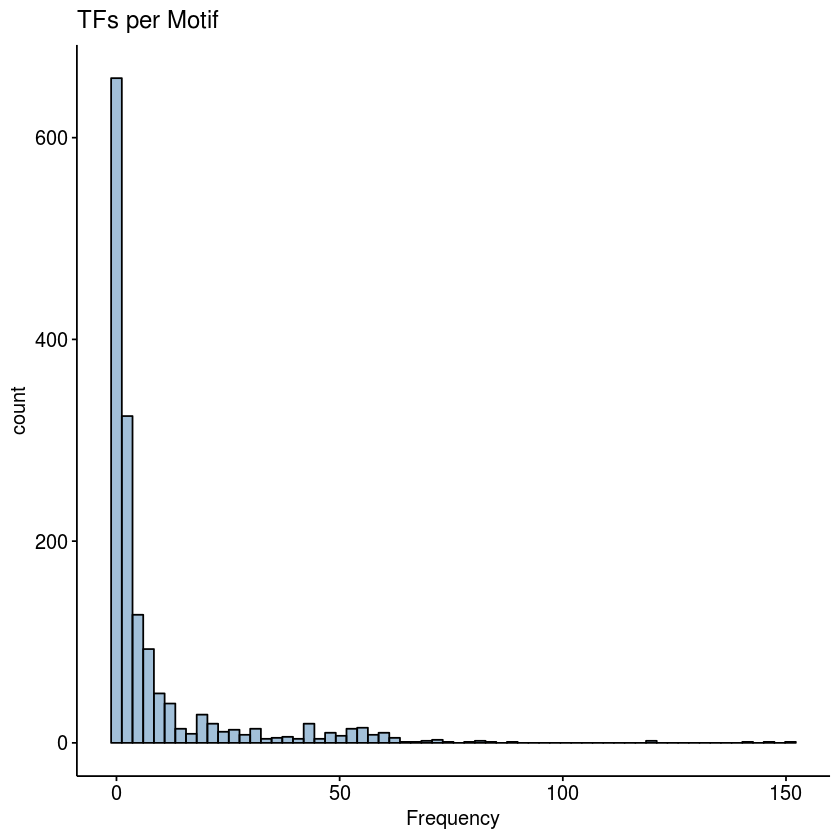

In [7]:
# Turn it around: how many TFs per motif?
# Make a plot of all TFs and their # of motifs
tf.motifs %>% group_by(Motif) %>%
    summarise(Frequency = n()) %>%
    arrange(desc(Frequency)) %>%
    gghistogram(x = "Frequency", 
                color = "black", 
                fill = "steelblue",
                bins = 64, 
                title = "TFs per Motif"
                ) -> tfs.per.motif
tfs.per.motif

In [10]:
# Save the figures
tfs.per.motif %>% ggexport(filename = "./tfsPerMotif.png")
motifs.per.tf %>% ggexport(filename = "./motifsPerTF.png")

file saved to ./tfsPerMotif.png
file saved to ./motifsPerTF.png
